# Reducing Churn

## Project Planning

### Goals

We will provide actionable, data-driven recommendations for reducing churn. We will achieve this by analyzing available customer data in order to identify drivers of churn.  We hope to arrive at 1 or more theories related to causal relationships around churn.  

### Deliverables

1. Notebook detailing my analysis in a way that can be reproduced. 
2. Report summarizing my findings that can be emailed to all stakeholders
3. A presentation to our product and customer relationship leadership team delivering the recommendations and the reasons for those recommendations.  


### Data Dictionary & Details

- churn:  We define churn as having discontinued all services.  
- monthly_charges:  The monthly_charges are the 'current monthly charges' (when the data was collected), or the last charges prior to churn.  
- The services listed are those that are present when the data was collected or at the point of churn.  

In [75]:
import pandas as pd
from env import user, host, pw

def get_connection(db, user, host, password):
    from sqlalchemy import create_engine
    url = f'mysql+pymysql://{user}:{password}@{host}/{db}'
    return create_engine(url)

conn = get_connection('telco_churn', user, host, pw)

df = pd.read_sql('SELECT c.*,p.payment_type, i.internet_service_type, t.contract_type \
                    FROM customers c \
                    JOIN payment_types p ON c.payment_type_id = p.payment_type_id \
                    JOIN internet_service_types i \
                        ON c.internet_service_type_id = i.internet_service_type_id \
                    JOIN contract_types t ON c.contract_type_id = t.contract_type_id;', 
                 conn)

In [76]:
variables = pd.DataFrame(df.columns, columns=['variable_name'])
variables

,variable_name
0,customer_id
1,gender
2,senior_citizen
3,partner
4,dependents
5,tenure
6,phone_service
7,multiple_lines
8,internet_service_type_id
9,online_security


In [77]:
vars_to_define = ['payment_type', 'internet_service_type', 'contract_type']
for var in vars_to_define:
    print(var)
    print(df[var].value_counts().head())
    print('\n')

payment_type
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_type, dtype: int64


internet_service_type
Fiber optic    3096
DSL            2421
None           1526
Name: internet_service_type, dtype: int64


contract_type
Month-to-month    3875
Two year          1695
One year          1473
Name: contract_type, dtype: int64




### Initial Thoughts, Ideas, Hypotheses

- My experience with telco has demonstrated the best prices come in the beginning and with a contract.  Sign up with a 1 year or 2 year contract and you will get a great deal, along with some free movie channels often.  The free movie channels usually expire after 3-6 months, in my experience.  They remain on the service but the customer begins getting charged for them.  After the sign-on deal is over, the price generally jumps anywhere from 25-50% from the original sign-up prices.  


- When customers call to cancel, I have experience an attempt to save the customer by offering another deal along with a contract.  I generally don't take those offers because by the time I reach that point, I am ready to leave. 


- The addition of fiber internet has added some interesting competition and movement.  Because fiber is in its infancy, the prices have started out higher but continue to drop as more companies are able to offer the option.  I have a hunch fiber might be leading to some migration of customers.  


- Senior citizens could impact in a couple of ways I can think of:  

    1. They could be less likely to churn, with possible attribution being lack of awareness of where to go or difficulty in adapting to a new service, new remote, etc.
    
    2. They could be more likely to churn due to pressure from other companies targeting senior citizens and taking advantage of their less experience in technology and the telco services.  
    
    
- I might think that automatic payments, and especially bank transfer, would be less likely to churn, thinking that those with automatic payments are more removed from the cost and any changes in cost, as well as more removed from a negative touchpoint of customer/service provider relationship leaving them to just focus on their experience of the service of tv and/or internet.  


- It could be reasonable to think that customers with land-lines are less likely to churn due to the extra challenges of porting numbers and lines.  


- I hypothesize that those with the most services and most diversity of services are less likely to churn due to the work required to transfer services.  Especially those with online backup.  


- If we control for services and watch the changes in prices over time, is there a difference in the percent increase in price over time for those who churn vs. those who don't?  Or is there a difference in the starting price?  Or a difference in the average price?  Or a difference in the most recent price, controlling for tenure? 


- It seems likely that month-to-month customers will churn more often, given that they have more opportunities to do so.  If we compare these customers with contract customers and look at annual churn, do those differences still exist?  What are the price differences in month-to-month?  Is there a max point price difference that will drive more customers to contract (if we find overall the contract customers churn less)? 

## Data Acquisition

### Environment Set-up

In [78]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# plt.style.use('classic')

# Modeling
import statsmodels.api as sm

from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

### Acquire via SQL

In [79]:
conn = get_connection('telco_churn', user, host, pw)

df = pd.read_sql('SELECT c.*,p.payment_type, i.internet_service_type, t.contract_type \
                    FROM customers c \
                    JOIN payment_types p ON c.payment_type_id = p.payment_type_id \
                    JOIN internet_service_types i \
                        ON c.internet_service_type_id = i.internet_service_type_id \
                    JOIN contract_types t ON c.contract_type_id = t.contract_type_id;', 
                 conn)

### Summarize

In [80]:
def summarize_df(df):
    print("Summary of Data\n")
    print("Rows & Columns:\n")
    print(df.shape)
    print("Variables:\n")
    var_names = df.columns.values
    print(var_names)
    print("\nColumn Info:\n")
    print(df.info())
    print("\nNumeric Summary Stats:\n")
    print(df.describe())
    print("\nTop 5 Values:\n")
    for var in var_names:
        print(var+":")
        print(df[var].value_counts().head())
        print('\n')
    print("\nMissing Values:\n")
    null_counts = df.isnull().sum()
    if len(null_counts[null_counts > 0]) == 0:
        print("No missing values")
    else:
        print(null_counts[null_counts > 0])
    print("\nFirst 5 rows:\n")
    print(df.head())
    print("\nEnd of Summary")

In [81]:
summarize_df(df)

Summary of Data

Rows & Columns:

(7043, 24)
Variables:

['customer_id' 'gender' 'senior_citizen' 'partner' 'dependents' 'tenure'
 'phone_service' 'multiple_lines' 'internet_service_type_id'
 'online_security' 'online_backup' 'device_protection' 'tech_support'
 'streaming_tv' 'streaming_movies' 'contract_type_id' 'paperless_billing'
 'payment_type_id' 'monthly_charges' 'total_charges' 'churn'
 'payment_type' 'internet_service_type' 'contract_type']

Column Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
internet_service_type_id    7043 no

## Data Preparation

1. Remove any variables I won't use
2. Convert object or category variables to numeric
3. Plot the distribution of monthly_charges, total_charges, and tenure


#### 1. Remove Variables

In [82]:
df.groupby(['contract_type','contract_type_id'])['customer_id'].count()

contract_type   contract_type_id
Month-to-month  1                   3875
One year        2                   1473
Two year        3                   1695
Name: customer_id, dtype: int64

In [83]:
df.groupby(['internet_service_type', 'internet_service_type_id'])['customer_id'].count()

internet_service_type  internet_service_type_id
DSL                    1                           2421
Fiber optic            2                           3096
None                   3                           1526
Name: customer_id, dtype: int64

In [84]:
df.groupby(['payment_type', 'payment_type_id'])['customer_id'].count()

payment_type               payment_type_id
Bank transfer (automatic)  3                  1544
Credit card (automatic)    4                  1522
Electronic check           1                  2365
Mailed check               2                  1612
Name: customer_id, dtype: int64

In [85]:
cols_to_remove = ['customer_id', 'internet_service_type', 'contract_type', 
                  'payment_type', 'phone_service']
df_short = df.drop(cols_to_remove, axis=1)
df_short.columns.values

array(['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'multiple_lines', 'internet_service_type_id', 'online_security',
       'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract_type_id',
       'paperless_billing', 'payment_type_id', 'monthly_charges',
       'total_charges', 'churn'], dtype=object)

#### 2. Convert to Numeric

Using the value counts from our initial summary, I will make the following changes to these variables:

I can change all of these with the same function: 

- partner: change to has_partner (1 if 'Yes',0)  

- dependents: change to has_dependents (1 if 'Yes',0)  

- online_security: change to has_online_security (1 if 'Yes', 0)  

- online_backup: change to has_online_backup (1 if 'Yes', 0)  

- device_protection: change to has_device_protection (1 if 'Yes', 0)  

- tech_support: change to has_tech_support (1 if 'Yes', 0)  

- streaming_tv: change to has_streaming_tv (1 if 'Yes', 0)  

- streaming_movies: change to has_streaming_movies (1 if 'Yes', 0)  

- paperless_billing: change to has_paperless_billing (1 if 'Yes', 0)


These I will do separately:

- gender:  change to is_female (1 if 'Female', 0)  

- multiple_lines: change to phone_service (0 if 'No phone service', 1 if 'No', 2 if 'Yes')


In [86]:
def change_to_boolean(x):
    if x == 'Yes':
        new_val = 1
    else:
        new_val = 0
    return new_val

In [87]:
cols_to_bool = ['churn', 'partner', 'dependents', 'online_security', 'online_backup', 'paperless_billing',
                'device_protection','tech_support', 'streaming_tv', 'streaming_movies']

for col in cols_to_bool:
    new_col_name = 'has_'+col
    df_short[new_col_name] = df_short[col].apply(lambda x: change_to_boolean(x))
    df_short = df_short.drop([col], axis=1)

In [88]:
def is_female(x):
    if x == 'Female':
        new_val = 1
    else:
        new_val = 0
    return new_val

def phone_service(x):
    if x == 'Yes':
        new_val = 2
    elif x == 'No':
        new_val = 1
    else:
        new_val = 0
    return new_val

In [89]:
df_short['is_female'] = df_short['gender'].apply(lambda x: is_female(x))
df_short['phone_service_id'] = df_short['multiple_lines'].apply(lambda x: phone_service(x))

df_short = df_short.drop(['gender', 'multiple_lines'], axis=1)

In [90]:
df_short.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
senior_citizen              7043 non-null int64
tenure                      7043 non-null int64
internet_service_type_id    7043 non-null int64
contract_type_id            7043 non-null int64
payment_type_id             7043 non-null int64
monthly_charges             7043 non-null float64
total_charges               7043 non-null object
has_churn                   7043 non-null int64
has_partner                 7043 non-null int64
has_dependents              7043 non-null int64
has_online_security         7043 non-null int64
has_online_backup           7043 non-null int64
has_paperless_billing       7043 non-null int64
has_device_protection       7043 non-null int64
has_tech_support            7043 non-null int64
has_streaming_tv            7043 non-null int64
has_streaming_movies        7043 non-null int64
is_female                   7043 non-null int64
phone_service_id          

Now we can see that total_charges is the only remaining non-numeric variable. 

In [91]:
df_short.sort_values(['total_charges'], ascending=True).head(10)

,senior_citizen,tenure,internet_service_type_id,contract_type_id,payment_type_id,monthly_charges,total_charges,has_churn,has_partner,has_dependents,has_online_security,has_online_backup,has_paperless_billing,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies,is_female,phone_service_id
6605,0,0,3,3,2,20.25,,0,0,1,0,0,0,0,0,0,0,0,1
5603,0,0,1,3,3,52.55,,0,1,1,1,0,1,1,1,1,0,1,0
5584,0,0,1,3,2,73.35,,0,1,1,0,1,0,1,1,1,0,1,2
5687,0,0,1,3,2,80.85,,0,1,1,1,1,0,1,0,1,1,1,1
6615,0,0,3,3,2,25.35,,0,1,1,0,0,0,0,0,0,0,0,2
5086,0,0,3,2,2,19.70,,0,1,1,0,0,1,0,0,0,0,0,1
6686,0,0,3,3,2,25.75,,0,1,1,0,0,0,0,0,0,0,0,2
6569,0,0,3,3,2,20.00,,0,1,1,0,0,0,0,0,0,0,1,1
6895,0,0,3,3,2,19.85,,0,1,1,0,0,0,0,0,0,0,0,1
5433,0,0,1,3,4,56.05,,0,1,1,1,1,0,1,1,1,0,1,0


In [92]:
df_short['total_charges'] = df_short['total_charges'].replace(r'\s+', np.nan, regex=True)
df_short.isnull().sum()

senior_citizen               0
tenure                       0
internet_service_type_id     0
contract_type_id             0
payment_type_id              0
monthly_charges              0
total_charges               11
has_churn                    0
has_partner                  0
has_dependents               0
has_online_security          0
has_online_backup            0
has_paperless_billing        0
has_device_protection        0
has_tech_support             0
has_streaming_tv             0
has_streaming_movies         0
is_female                    0
phone_service_id             0
dtype: int64

In [94]:
# change to numeric
df_short = df_short.fillna(0)
df_short.isnull().sum()

senior_citizen              0
tenure                      0
internet_service_type_id    0
contract_type_id            0
payment_type_id             0
monthly_charges             0
total_charges               0
has_churn                   0
has_partner                 0
has_dependents              0
has_online_security         0
has_online_backup           0
has_paperless_billing       0
has_device_protection       0
has_tech_support            0
has_streaming_tv            0
has_streaming_movies        0
is_female                   0
phone_service_id            0
dtype: int64

#### 3. Plot the distribution

##### monthly_charges, total_charges, and tenure

In [ ]:
plt.figure(figsize=(16,6))

for i, col in enumerate(['monthly_charges', 'total_charges', 'tenure']):
    plot_number = i + 1
    series = df_short[col]
    plt.subplot(1,3,plot_number)
    plt.title(col)
    series.hist(bins=20, density=True, cumulative=False, log=False)

KeyboardInterrupt: 

## Data Exploration

In [38]:
X = df_.drop(['churn']
y = df[['churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=123)

KeyError: "None of [['churn']] are in the [index]"

In [36]:
with sns.axes_style('white'):
    j = sns.jointplot("monthly_charges", "total_charges", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

NameError: name 'train' is not defined

## Data Modeling 

Month-to-month    3875
Two year          1695
One year          1473
Name: contract_type, dtype: int64

## Project Overview

### Background: 


Zillow wants to improve their Zestimate.  The zestimate is estimated value of a home.  Zillow theorizes that there is more information to be gained to improve its existing model.  Because of that, Zillow wants you to develop a model to predict the error between the Zestimate and the sales price of a home.  In predicting the error, you will discover features that will help them improve the Zestimate estimate itself.  Your goal of this project is to develop a linear regression model that will best predict the log error of the Zestimate.  The error is the difference of the sales price and the Zestimate.  The log error is computed by taking the log function of that error.  You don't need to worry about the fact that the error is of a logarithmic function.  It is a continuous number that represents an error rate. 

## Data Preparation

1. Sample the data.  Why?  So you can confirm the data look like what you would expect.
2. Create a variable, `colnames`, that is a list of the column names.  Why?  You will likely reference this variable later. 
3. Identify the data types of each variable.  Why? You need to make sure they are what makes sense for the data and the meaning of the data that lies in that variable.  If it does not, make necessary changes.  
4. Compute the summary statistics for the variables.  Why?  The get a glimpse into outliers, skewness, spread, central tendency.  
5. Identify the columns that have missing values and the number of missing values in each column. Why? Missing values are going to cause issues down the line so you will need to handle those appropriately.  For each variable with missing values, if it makes sense to replace those missing with a 0, do so.  For those where that doesn't make sense, decide if you should drop the entire observations (rows) that contain the missing values, or drop the entire variable (column) that contains the missing values. 
6. Create a list of the independent variable names (aka attributes) and assign it to the variable `attributes`. Why? During exploration, you will likely use this list to refer to the attribute names. 
7. Clearly identify your dependent (target) variable.  What is the name of the variable? Is it discrete or continuous?
8. Plot a histogram and box plot of each variable.  Why?  To see the distribution, skewness, outliers, and unit scales.  You will use this information in your decision of whether to normalize, standardize or neither. 
9. Bonus: Create a new data frame that is the min-max normalization of the independent variable in the original data frame (+ the original dependent variable).  You will normalize each of the independent variables independently, i.e. using the min and max of each variable, not the min/max of the whole dataframe. Why?  Regression is very sensitive to difference in units.  It will be almost impossible to extract a meaningful linear regression model with such extreme differences in scale.  For more context, see: https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc


## Data Exploration

1. Split data into training and test datasets
2. Address each of the questions you posed in your planning & brainstorming through visual or statistical analysis.  
3. Create a jointplot for each independent variable (normalized version) with the dependent variable.  Use your for loop created in the exercises to run through the plotting of each independent variable.  Be sure you have Pearson's r and p-value annotated on each plot.  
4. Create a feature plot using seaborn's PairGrid() of the interaction between each variable (dependent + independent).  You will want to use the normalized dataframe so you can more clearly view the interactions.  
5. Create a heatmap of the correlation between each variable pair.  
6. Summarize your conclusions from these steps. 
7. Is the logerror significantly different for homes with 3 bedrooms vs those with 5 or more bedrooms?  Run a t-test to test this difference.  
8. Do the same for another 2 samples you are interested in comparing (e.g. those with 1 bath vs. x baths)

## Data Modeling

### Feature Engineering & Selection

1. Are there new features you could create based on existing features that might be helpful?  Come up with at least one possible new feature that is a calculation from 2+ existing variables.  Add that feature and update the normalized dataframe with the min-max normalization of that feature. 
2. Use statsmodels ordinary least squares to assess the importance of each feature with respect to the target (using the normalized dataframe)
3. Summarize your conclusions and next steps from your analysis in step 2.  What will you try when developing your model?  (which features to use/not use/etc)

#### Train & Test Model

1. Fit, predict (in-sample) & evaluate multiple linear regression models to find the best one.
2. Make any changes as necessary to improve your model.
3. Identify the best model after all training and predict & evaluate on out-of-sample data.  
4. Plot the residuals from your out-of-sample predictions.  
5. Summarize your expectations about how you estimate this model will perform in production.

# Linear Regression in Python


## Goals

### Learning Agenda

Use Python (Pandas, Matplotlib, Scipy, Scikit-Learn) to perform regression

### Example Challenge

1. Predict students' final grades using the first exam of the semester
2. Predict students' final grades using the first three exams of the semester

## The Plan

1. Prepare the Environment
1. Pandas:  read a local csv
2. Pandas:  sample and summarize
3. Pandas:  ensure no null values
4. SKlearn: split into test/train
6. Matplotlib & Seaborn: Explore
7. Scipy: Pearson's correlation
8. Statsmodels: Feature Selection
9. Scikit-Learn: Fit Linear Regression Models, In-Sample Predictions
10. Scikit-Learn: In-Sample Evaluations
11. Scikit-Learn: Make any changes needed & repeat 9-10 as needed
12. Scikit-Learn: Out-of-sample predictions using best model
13. Exercises

### 1. Prepare the Environment

In [59]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')

# Modeling
import statsmodels.api as sm

from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

### 2. Pandas:  read a local csv

In [60]:
path = './'
df = pd.read_csv(path + "student_grades.csv")

### 3. Pandas:  sample and summarize

In [61]:
df.head()

,student_id,exam1,exam2,exam3,final_grade
0,1,100,90,95,96
1,2,98,93,96,95
2,3,85,83,87,87
3,4,83,80,86,85
4,5,93,90,96,97


In [62]:
df.shape

(104, 5)

In [63]:
df.describe()

,student_id,exam1,exam2,exam3,final_grade
count,104.000000,104.000000,104.000000,104.000000,104.000000
mean,52.500000,78.461538,77.307692,84.153846,81.692308
std,30.166206,14.284844,10.295703,8.714199,10.918122
min,1.000000,57.000000,65.000000,70.000000,65.000000
25%,26.750000,70.000000,70.000000,78.000000,72.000000
50%,52.500000,79.000000,75.000000,85.000000,81.000000
75%,78.250000,92.000000,89.000000,94.000000,93.000000
max,104.000000,100.000000,93.000000,96.000000,97.000000


> ### Exercise
Extract information from the results of describe in order to compute IQR and range
> ```python
> IQR = 
> Range = 
> ```

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
student_id     104 non-null int64
exam1          104 non-null int64
exam2          104 non-null int64
exam3          104 non-null int64
final_grade    104 non-null int64
dtypes: int64(5)
memory usage: 4.1 KB


### 4. Pandas:  ensure no null values

The above can tell you something about missing values when you compare the *entries* with each fields *non-null* values.  You can also do this for a more direct compuation:

In [65]:
print(df.isnull().sum())

# or  print(df.columns[df.isnull().any()])

student_id     0
exam1          0
exam2          0
exam3          0
final_grade    0
dtype: int64


### 5. Distribution, Skewness, Normalization & Standardization

Plot histograms &/or boxplots to see the distribution, skewness, outliers, and unit scales.  You will use this information in your decision of whether to normalize, standardize or neither. 

#### Histogram

There are 2 ways we can go about plotting histograms for multiple variables. 

1. melt the data frame into a long data set and use seaborn's 'FacetGrid' to plot each histogram quickly.
2. use matplotlib with subplots

##### Melt data and use FacetGrid to plot histogram

In [66]:
# we will create a melted version of train for visualization purposes
df_melted = pd.melt(df, id_vars=['student_id'], value_vars=['exam1','exam2','exam3','final_grade'], 
                    var_name='grade_type', value_name='score')

In [67]:
df_melted['grade_type'].value_counts()

exam3          104
final_grade    104
exam2          104
exam1          104
Name: grade_type, dtype: int64

In [68]:
df_melted['score'].value_counts(bins=10, sort=False)

(56.956, 61.3]    16
(61.3, 65.6]      40
(65.6, 69.9]       8
(69.9, 74.2]      72
(74.2, 78.5]      56
(78.5, 82.8]      32
(82.8, 87.1]      64
(87.1, 91.4]      24
(91.4, 95.7]      56
(95.7, 100.0]     48
Name: score, dtype: int64

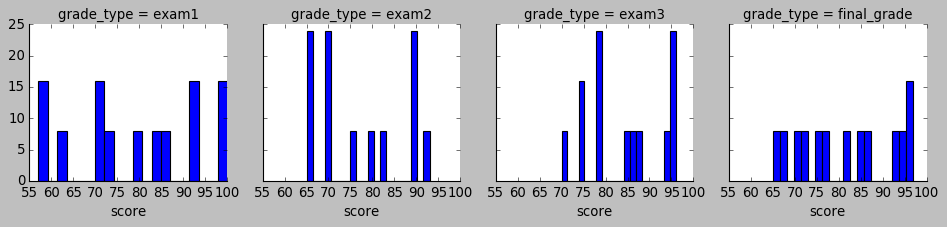

In [69]:
# Histogram
grid = sns.FacetGrid(df_melted, col="grade_type", margin_titles=True)
grid.map(plt.hist, "score", bins=20);

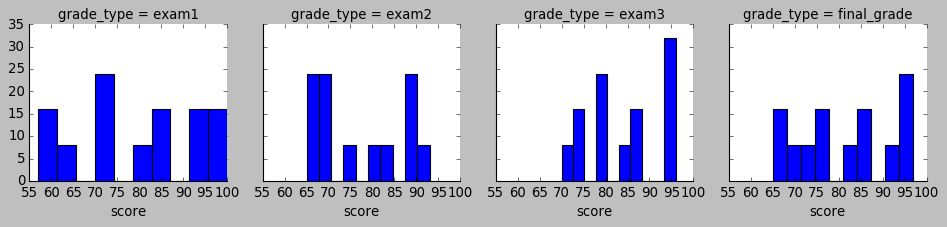

In [70]:
grid = sns.FacetGrid(df_melted, col="grade_type", margin_titles=True)
grid.map(plt.hist, "score", bins=10);

##### Using matplotlib with subplots

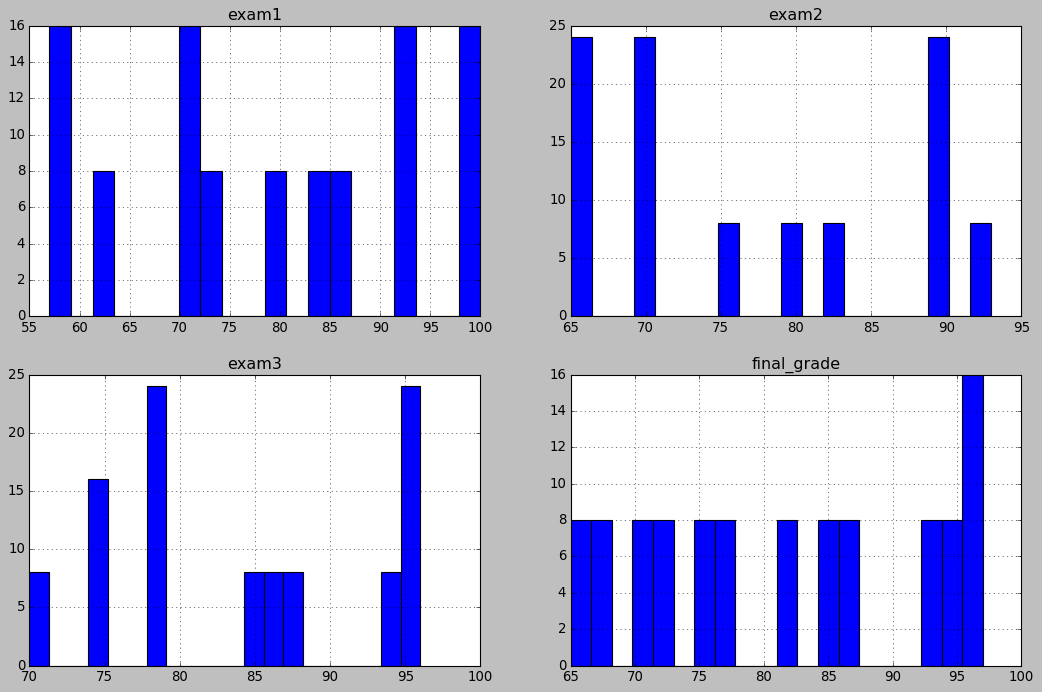

In [71]:
plt.figure(figsize=(16, 10))

for i, col in enumerate(['exam1', 'exam2', 'exam3', 'final_grade']):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df[col]  
    plt.subplot(2, 2, plot_number)
    plt.title(col)
    series.hist(bins=20, density=False, cumulative=False, log=False)

Look at the above loop step by step. 

> 1. enumerate

In [72]:
ix_col_list = list(enumerate(['exam1', 'exam2', 'exam3', 'final_grade']))
print(for_list)
ex1_ix_col_tuple = for_list[0]
print(ex1_ix_col_tuple) 
ex1_index = ex1_ix_col_tuple[0]
print(ex1_index)

[(0, 'exam1'), (1, 'exam2'), (2, 'exam3'), (3, 'final_grade')]
(0, 'exam1')
0


> 2. Assign the first index, 0, to i
> 3. Assign the first column name, 'exam1', to col

In [73]:
i = ex1_ix_col_tuple[0]
print("The first item of the tuple is the index.  The first index = %.0f" % i)
col = ex1_ix_col_tuple[1]
print("The second item of the tuple is the column name.  The first column name = %s" % col)

The first item of the tuple is the index.  The first index = 0
The second item of the tuple is the column name.  The first column name = exam1


> 4. Using index = 0 and column of 'exam1', assign the variable plot_number to the first plot (1), and create a series of all the values. 

In [74]:
plot_number = i + 1 # i starts at 0, but plot nos should start at 1
print("plot_number: %.0f" % plot_number)
series = df[col]
print("Number of grades in the series: %.0f" % series.shape[0])
print(series.head())

plot_number: 1
Number of grades in the series: 104
0    100
1     98
2     85
3     83
4     93
Name: exam1, dtype: int64


> 5. Create the subplot object

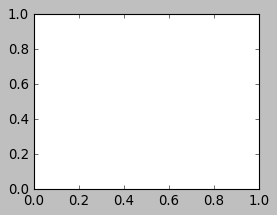

In [75]:
plt.subplot(2, 2, plot_number) # plot number = 1

> 6. Add the title

Text(0.5, 1.0, 'exam1')

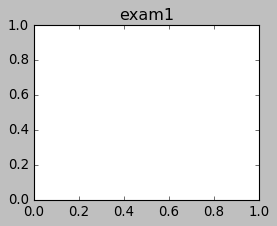

In [76]:
plt.subplot(2, 2, plot_number) # plot number = 1
plt.title(col) # plot title = 'exam1'

> 7. Add the histogram

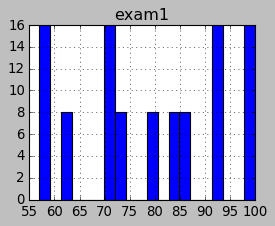

In [77]:
plt.subplot(2, 2, plot_number) # plot number = 1
plt.title(col) # plot title = 'exam1'
series.hist(bins=20, density=False, cumulative=False, log=False) # plot the histogram

#### Box Plot

seaborn will default to plotting *all* the numeric variables if we don't specify specific x and y values. This is the behavior we want, except we don't want to plot the `student_id` column.

We'll use the `.drop` method to remove the `student_id` column from the data frame. Recall that `.drop` will produce a new data frame without the specified column(s), but will not modify the original data frame.

In [78]:
df.drop(columns=['student_id']).head()

,exam1,exam2,exam3,final_grade
0,100,90,95,96
1,98,93,96,95
2,85,83,87,87
3,83,80,86,85
4,93,90,96,97


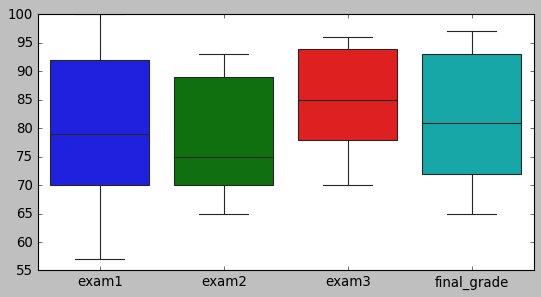

In [79]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df.drop(columns=['student_id']))

### 6. SKlearn: split into test/train

In [99]:
# test_train_split
X = df.drop(['final_grade','student_id'], axis=1)
print(X.head())

y = df[['final_grade']]
print(y.head())

   exam1  exam2  exam3
0    100     90     95
1     98     93     96
2     85     83     87
3     83     80     86
4     93     90     96
   final_grade
0           96
1           95
2           87
3           85
4           97


In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

In [117]:
train = pd.concat([X_train, y_train], axis=1)
print("Train columns:  %s" % list(train.columns))
print("Train dimensions (rows, columns):", train.shape)

Train columns:  ['exam1', 'exam2', 'exam3', 'final_grade']
Train dimensions (rows, columns): (83, 4)


In [118]:
test = pd.concat([X_test, y_test], axis=1)
print("Test columns:  %s" % list(test.columns))
print("Test dimensions (rows, columns):", test.shape)

Test columns:  ['exam1', 'exam2', 'exam3', 'final_grade']
Test dimensions (rows, columns): (21, 4)


Below we show some python code that validates that the splits are what we would expect. That is, we ensure that:

- the number of rows in both the x and y training data set are equal
- the number of rows in both the x and y testing data set are equal
- the number of columns in the training and test data sets are the same
- the training data set is 80% of the original data, the test set is 20%

In [119]:
if X_train.shape[0] == y_train.shape[0]:
    print("X & y train rows ARE equal")
else:
    print("X & y train rows ARE NOT equal")


if X_test.shape[0] == y_test.shape[0]:
    print("X & y test rows ARE equal")
else:
    print("X & y test rows ARE NOT equal")

if train.shape[1] == test.shape[1]:
    print("Number of columns in train & test ARE equal")
else:
    print("Number of columns in train & test ARE NOT equal")
 
train_split = train.shape[0] / (train.shape[0] + test.shape[0])
test_split = test.shape[0] / (train.shape[0] + test.shape[0])

print("Train Split: %.2f" % train_split)
print("Test Split: %.2f" % test_split)

X & y train rows ARE equal
X & y test rows ARE equal
Number of columns in train & test ARE equal
Train Split: 0.80
Test Split: 0.20


### 7. Matplotlib & Seaborn: Explore

- Graphs are many and are quickly made
- Axis and labels are cleaned up later
- Color and size are used for information, not asthetics
- Graph types include box plts, heatmaps, histograms, density plots, feature or correlation plots  


1. Jointplot: Scatterplot with Density Plots
2. PairGrid: Scatterplots with Histograms
3. Heatmap

#### Scatterplot + Density Plots

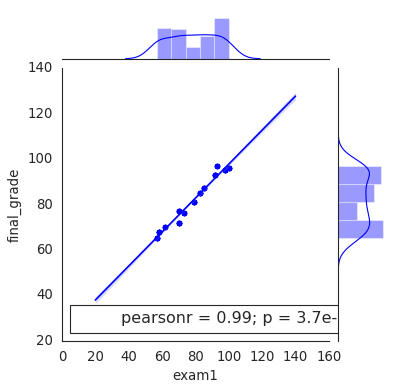

In [120]:
with sns.axes_style('white'):
    j = sns.jointplot("exam1", "final_grade", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

### 7.1_Exercise

1. Write a for loop to plot each of the 3 features with final_grade using a jointplot.
2. What can you say about each relationship (using pearson's r and the p-value)

#### Histogram + Scatterplots

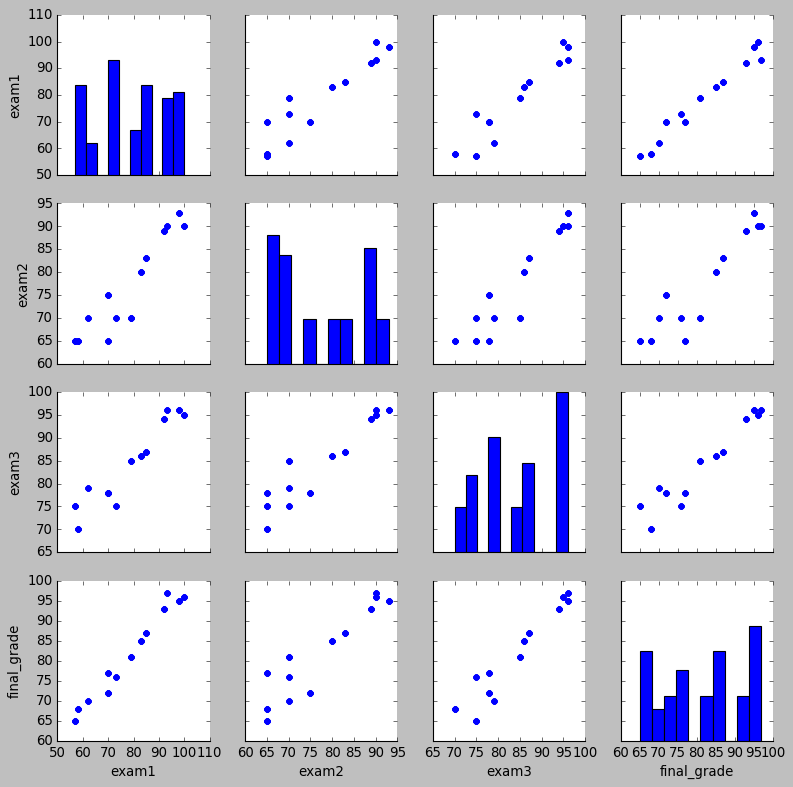

In [121]:
# This is roughly equivalent to sns.jointplot, but we see here that we have the
# flexibility to customize the type of the plots in each position.

g = sns.PairGrid(train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);

#### Heatmap

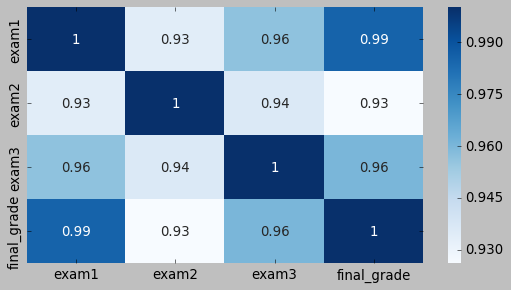

In [122]:
plt.figure(figsize=(8,4))
sns.heatmap(train.corr(), cmap='Blues', annot=True)

### 7.2_Exercise

1. Plot a boxplot and heatmap side by side using subplots

### 8. Scipy: Pearson's Correlation

#### stats.pearsonr

In [123]:
pearsonr(X_train[['exam1']], y_train)

(array([0.98548827]), array([3.67959731e-64]))

#### List Comprehension 

In [124]:
[[column, pearsonr(train[column], train.final_grade)] for column in X_train] 

[['exam1', (0.9854882734738365, 3.679597306767771e-64)],
 ['exam2', (0.9260773842724218, 4.9387065956533756e-36)],
 ['exam3', (0.9604227932900589, 1.0003417783597307e-46)]]

#### Create Dictionary

In [125]:
column_names = X_train.columns
r_and_p_values = [pearsonr(X_train[col], y_train.final_grade) for col in column_names]

exam_final_corr_dict = dict(zip(column_names, r_and_p_values))
exam_final_corr_dict

{'exam1': (0.9854882734738365, 3.679597306767771e-64),
 'exam2': (0.9260773842724218, 4.9387065956533756e-36),
 'exam3': (0.9604227932900589, 1.0003417783597307e-46)}

### 9. Statsmodels: Feature Selection

#### Feature selection using statsmodels.OLS (Ordinary Least Squares)



In [127]:
ols_model = sm.OLS(y_train, X_train)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            final_grade   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 5.103e+04
Date:                Tue, 19 Mar 2019   Prob (F-statistic):          3.76e-131
Time:                        12:03:33   Log-Likelihood:                -170.25
No. Observations:                  83   AIC:                             346.5
Df Residuals:                      80   BIC:                             353.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
exam1          0.4555      0.036     12.625      0.000       0.384       0.527
exam2         -0.0307      0.063     -0.486      0.629      -0.157       0.095
exam3          0.5728      0.049     11.633      0.000       0.475       0.671
==============================================================================
Omnibus:                       30.491   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.671
Skew:                           0.427   Prob(JB):                       0.0216
Kurtosis:                       1.780   Cond. No.                         51.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Conclusion

Looking at the p-values of the 3 exams, I am going to remove exam2 from the features as we are not seeing any significance of that with the final grade, our target variable.

I will now use sklearn to create a model using exam 1, exam3 and exam 1 & 3 to compare results.

(well, I will model exam 1 (lm1) and exam 1 & 3 (lm2), and you will test exam 3 alone (lm3))


### 10. Scikit-Learn: Fit Linear Regression Models, In-Sample Predictions

Generally speaking, we'll use scikit-learn like this:

1. Import the class(es) that we intend on using (we've already done this)
1. Split the data into training and test (we've already done this)
1. Create an instance of the class(es) to use
1. Fit the model(s) with the training data
1. Use the model(s) to make predictions
1. Evaluate the performance of the model(s)

We'll create two separate models: one that is based solely on exam 1, and one that is based on exam 1 and exam 2.

#### Linear Model 1

##### Create the linear regression object

In [179]:
# Create linear regression objects
lm1 = LinearRegression()
print(lm1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


##### Fit/Train the model

This is where we feed the training data into the models, and model parameters are "learned". 

Let's take a look at the linear model and the parameters (y_intercept & coefficients) that the model calulated. 

In [177]:
lm1.fit(X_train[['exam1']], y_train)
print(lm1)

lm1_y_intercept = lm1.intercept_
print(lm1_y_intercept)

lm1_coefficients = lm1.coef_
print(lm1_coefficients)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[22.88211318]
[[0.74850854]]


Given the intercept and the coefficients, we can write the regression function. 

In [178]:
print('Univariate - final_exam = b + m * exam1')
print('    y-intercept (b): %.2f' % lm1_y_intercept)
print('    coefficient (m): %.2f' % lm1_coefficients[0])
print()

Univariate - final_exam = b + m * exam1
    y-intercept (b): 22.88
    coefficient (m): 0.75



!!!tip "sklearn conventions"
    Sklearn uses an underscore suffic to indicate properties which are learned from the data (as opposed to being inherit to the model itself.)

##### In-Sample Prediction

Now that we have a model, we can use the model to make predictions. We'll start by using our model to predict based on the test data set.

In [169]:
y_pred_lm1 = lm1.predict(X_train[['exam1']])

##### Train/In-Sample Evaluations
using sklearn.mean_squared_error and sklearn.r2_score.

Now let's take a look at a couple performance metrics for our models: the mean squared error and r-squared values.

In [170]:
mse_lm1 = mean_squared_error(y_train, y_pred_lm1)
print("lm1\n  mse: {:.3}".format(mse_lm1)) 

lm1
  mse: 3.37


In [171]:
r2_lm1 = r2_score(y_train, y_pred_lm1)

print('  {:.2%} of the variance in the student''s final grade can be explained by the grade on the first exam.'.format(r2_lm1))

  97.12% of the variance in the students final grade can be explained by the grade on the first exam.


#### linear model 2: lm2

#### Create the linear regression object

In [ ]:
lm2 = LinearRegression()
print(lm2)

##### Fit/Train the model

This is where we feed the training data into the models, and model parameters are "learned". 

Let's take a look at the linear model and the parameters (y_intercept & coefficients) that the model calulated. 

In [165]:
lm2.fit(X_train[['exam1', 'exam3']], y_train)
print(lm2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


Let's take a look at the parameters (y_intercept & coefficients) that the models calulated. 

In [167]:
lm2_y_intercept = lm2.intercept_
print(lm2_y_intercept)

lm2_coefficients = lm2.coef_
print(lm2_coefficients)

[12.79518052]
[[0.59709165 0.26106586]]


Given the intercept and the coefficients, we can write the regression function. 

In [168]:
print('Multivariate - final_exam = b + m1 * exam1 + m2 * exam3')
print('    y-intercept  (b): %.2f' % lm2_y_intercept)
print('    coefficient (m1): %.2f' % lm2_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm2_coefficients[0][1])

Multivariate - final_exam = b + m1 * exam1 + m2 * exam3
    y-intercept  (b): 12.80
    coefficient (m1): 0.60
    coefficient (m2): 0.26


##### In-Sample Prediction

Now that we have a model, we can use the model to make predictions. We'll start by using our model to predict based on the test data set.

In [172]:
y_pred_lm2 = lm2.predict(X_train.drop(columns=['exam2']))

##### Train/In-Sample Evaluations
using sklearn.mean_squared_error and sklearn.r2_score.

Now let's take a look at a couple performance metrics for our models: the mean squared error and r-squared values.

In [180]:
mse_lm2 = mean_squared_error(y_train, y_pred_lm2)
print("lm2\n  mse: {:.3}".format(mse_lm2)) 

lm2
  mse: 2.94


In [181]:
r2_lm2 = r2_score(y_train, y_pred_lm2)
print('  {:.2%} of the variance in the student''s final grade can be explained by the grades on exam 1 and 3.'.format(r2_lm2))

  97.49% of the variance in the students final grade can be explained by the grades on exam 1 and 3.


##### Compare the 2 models
We can visualize the predictions by plotting the predictions vs the actual values:

Text(0.5, 1.0, 'Predicted vs Actual Final Grade')

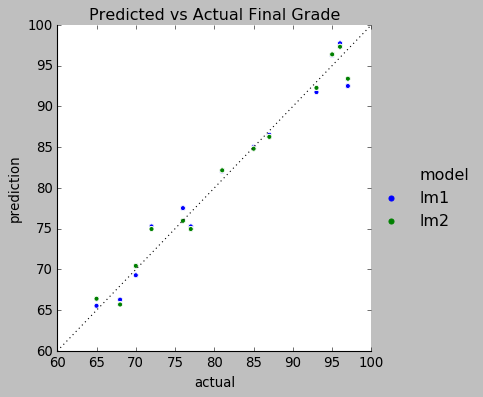

In [182]:
# the predictions are a 1 x 83 two dimensional matrix, but we want just
# a single array of predictions. We can use the .ravel method to achieve
# this.

pd.DataFrame({'actual': y_train.final_grade,
              'lm1': y_pred_lm1.ravel(),
              'lm2': y_pred_lm2.ravel()})\
    .melt(id_vars=['actual'], var_name='model', value_name='prediction')\
    .pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')

plt.plot([60, 100], [60, 100], c='black', ls=':')
plt.ylim(60, 100)
plt.xlim(60, 100)
plt.title('Predicted vs Actual Final Grade')

Here the line down the middle represents "perfect" prediction. The further away from this line the are, the farther off the prediction was.

### 12. Scikit-Learn: Make any changes needed & repeat 9-10 as needed

#### Exercise

1. What are your take-aways from the evaluation results above? 
2. Fit, predict, and evaluate one more model, lm3, using exam 3 only.
3. How does the result of the model compare to the other two?  Which should you use, based on these results? 

### 13. Scikit-Learn: Out-of-sample predictions using best model

#### Predict final grades using testing data

In [183]:
# Make predictions using the testing set
y_pred_lm2 = lm2.predict(X_test[['exam1', 'exam3']])

#### Evaluate performance

In [184]:
mse = mean_squared_error(y_test, y_pred_lm2)

print("Mean squared error: %.2f" % mse)

Mean squared error: 3.42


In [185]:
r2 = r2_score(y_test, y_pred_lm2)

print('{:.2%} of the variance in the student''s final grade can be explained by the grades on the first 3 exams.'
      .format(r2))

97.20% of the variance in the students final grade can be explained by the grades on the first 3 exams.


#### Plot Residuals

Text(0, 0.5, 'Residuals')

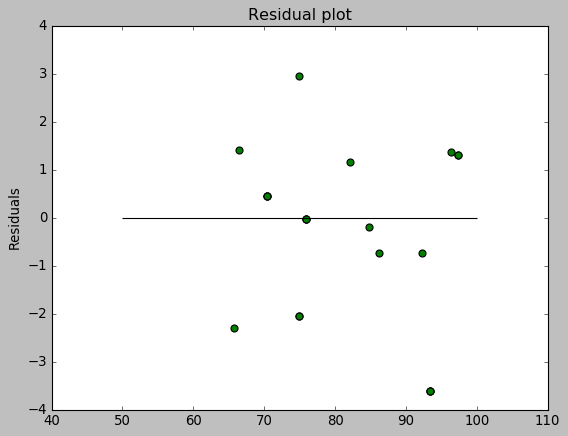

In [98]:
plt.scatter(y_pred_lm2, y_pred_lm2 - y_test, c='g', s=40)
plt.hlines(y=0, xmin=50, xmax=100)
plt.title("Residual plot")
plt.ylabel('Residuals')

## Further Reading

- [Standardization vs Normalization](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc)
- [Visualization with Seaborn](https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html)
- [Multiple Regression with `statsmodels`](https://nbviewer.jupyter.org/urls/s3.amazonaws.com/datarobotblog/notebooks/multiple_regression_in_python.ipynb    )

## Exercises:

1. Using the example data above:

    1. Extract information from the results of `.describe` and compute IQR and
       range of each exam and the final grade
    1. Write a for loop to plot each of the 3 features (exam 1, 2, & 3) with the
       final grade using a joint plot.  What can you say about each relationship
       (using pearson's r and the p-value)
    1. Plot the boxplot & heatmap side by side using 'subplot'
    1. What are your take-aways from the evaluation results of `lm1` and `lm2`?
    1. Fit, predict, and evaluate one more model, `lm3`, using exam 3 only.
    1. How does the result of the model compare to the other two?  Which should
       you use, based on these results?
    1. Predict final grades of the out-of-sample data (test dataframe) and
       evaluate results.
    1. Which model performs the best, based on the 2 out-of-sample evaluation
       results (the example one, `lm1`, and the exercise one, `lm3`, from the
       above exercise).

1. Using `telco_churn` database, predict total charges

    1. Using the `telco_churn` database, extract a table for each customer *with
       a 2-year contract* and include the following information customer id,
       tenure, monthly charges, and total charges.
    1. Export the table to a csv
    1. Create a jupyter notebook titled `regression`
    1. Prepare the Environment (do not copy and paste...manually type so that
       you remember what you need and why you are importing the things that you
       are. You will do this often!)
    1. Read the information from the `customers` table into a dataframe.
    1. How many rows are in your dataframe?
    1. What is the data type of the field containing the customer ids?
    1. Print to the notebook the last 10 rows of your dataframe.
    1. What is the inner quartile range of tenure? monthly charges? total
       charges?
    1. How many missing values are in each variable?
    1. Fill any missing values with 0.
    1. Show the ditribution of monthly charges through a histogram
    1. Create a new dataframe that contains tenure, monthly charges, and total
       charges, but not the customer id.
    1. Create a box plot of each variable in your new dataframe. This should be
       a single chart with 3 categorical plots, 1 each for tenure, monthly
       charges, total charges.
    1. Split your data into a test and train dataset. Set the `random_state` to
       `123`.  You should end up with 4 dataframes:  `X_train`, `X_test`,
       `y_train`, `y_test`.

1. Using the in-sample data (`X_train` and `y_train`)

    1. Create a scatterplot for each combination of variables.
    1. Create a heatmap containing the 3 variables.
    1. Compute pearson's correlation coefficient and print it's value in the
       sentence "Pearson's R is `____` with a significance p-value of `____`"
    1. Train (aka *fit*) a linear regression model, modeling total charges as a
       linear function of tenure.
    1. What is the y-intercept of the regression line?  Translate the intercept
       in plain english, i.e. what is means in the context of the data.
    1. What the slope of the regression line?  Translate the slope in plain
       english, i.e. what is means in the context of the data.
    1. Write the linear function in the form of $y = mx + b$ using the
       parameters that were estimated from the algorithm and the variable names
       for y and x specific to your data.
    1. Test your model on the training sample. That is, use your newly fit model
       to predict the total charges using tenure.
    1. Evaluate the model's performance using r-squared, mean squared error, and
       median absolute error.

1. Using the out-of-sample data (`X_test`, `y_test`)

    1. Test your model on the test sample.
    1. Evaluate your model's performance on test sample.  How do each of the
       metrics compare to that of the training sample? How can you explain the
       reason for the difference?
    1. Calculate the p-value of the regressor for the train and test sample.
       Hint: f_regression
    1. Create a scatter plot of the predicted values versus the actual values in
       the test sample.
    1. Create a scatter plot of the actual values of x and y in the test sample
       with the regression line layered over.
    1. Create a scatter plot of the residuals (x axis: predicted values of final
       grade, y axis: the residual values (remember definition of residual from
       previous lesson).  Layer over it a horizonal line that represents no
       residual.
